In [1]:
%config Completer.use_jedi = False

We import the different things we need, then we pre-process the data such as in the training notebook
===

In [62]:
from pathlib import Path
import importlib.util

import logging
logging.getLogger().setLevel(logging.INFO)

from sklearn import tree
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, balanced_accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn_pandas import DataFrameMapper

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier

import pandas as pd

import predictsignauxfaibles.models
from predictsignauxfaibles.data import SFDataset
from predictsignauxfaibles.config import OUTPUT_FOLDER, IGNORE_NA
from predictsignauxfaibles.pipelines import run_pipeline
from predictsignauxfaibles.utils import load_conf

In [3]:
conf = load_conf("default")

In [4]:
train = conf.TRAIN_DATASET
train.sample_size = 1e4

test = conf.TEST_DATASET
test.sample_size = 1e4

In [5]:
savepath = None # change it to be a filepath if you wish to save train and test data locally

train.fetch_data().raise_if_empty()
test.fetch_data().raise_if_empty()
logging.info("Succesfully loaded Features data from MongoDB")

if savepath is not None:
    train.data.to_csv(f"{savepath}_train.csv")
    test.data.to_csv(f"{savepath}_test.csv")
    logging.info(f"Saved Features extract to {savepath}")

INFO:root:Succesfully loaded Features data from MongoDB


In [6]:
train_siren_set = train.data["siren"].unique().tolist()
test.remove_siren(train_siren_set)

INFO:root:Removed 1408 from data based on SIREN blacklist



Signaux Faibles Dataset
----------------------------------------------------
            siret    periode  effectif  outcome  \
0  81426145900022 2018-08-01      18.0    False   
1  48918288100024 2018-08-01      94.0    False   
2  88879050800020 2018-08-01      29.0    False   
3  78396088300032 2018-07-01      11.0    False   
4  21030060400019 2018-08-01      12.0    False   

   montant_part_ouvriere_past_12  montant_part_patronale_past_12  \
0                            0.0                             0.0   
1                            0.0                             0.0   
2                            NaN                             NaN   
3                            0.0                             0.0   
4                            NaN                             NaN   

   montant_part_ouvriere_past_6  montant_part_patronale_past_6  \
0                           0.0                            0.0   
1                           0.0                            0.0   
2       

In [7]:
train.replace_missing_data().remove_na(ignore=IGNORE_NA)
train.data = run_pipeline(train.data, conf.TRANSFO_PIPELINE)

test.replace_missing_data().remove_na(ignore=IGNORE_NA)
test.data = run_pipeline(test.data, conf.TRANSFO_PIPELINE)

INFO:root:Removing NAs from dataset.
INFO:root:Number of observations before: 10000
INFO:root:Number of observations after: 2013
INFO:root:Checking that input columns are all there.
INFO:root:Running pipeline on data.
INFO:root:STEP 1: Remove Administrations
INFO:root:STEP 2: Make `paydex_yoy`
INFO:root:STEP 3: Make `paydex_group`
INFO:root:STEP 4: Make `avg_delta_dette_par_effectif`
INFO:root:Removing NAs from dataset.
INFO:root:Number of observations before: 8592
INFO:root:Number of observations after: 2664
INFO:root:Checking that input columns are all there.
INFO:root:Running pipeline on data.
INFO:root:STEP 1: Remove Administrations
INFO:root:STEP 2: Make `paydex_yoy`
INFO:root:STEP 3: Make `paydex_group`
INFO:root:STEP 4: Make `avg_delta_dette_par_effectif`


In [8]:
train.data

,siret,periode,effectif,outcome,montant_part_ouvriere_past_12,montant_part_patronale_past_12,montant_part_ouvriere_past_6,montant_part_patronale_past_6,montant_part_ouvriere_past_3,montant_part_patronale_past_3,...,productivite_capital_investi,rentabilite_economique,rentabilite_nette,ca,interets,apart_heures_consommees,apart_heures_consommees_cumulees,paydex_yoy,paydex_group,avg_delta_dette_par_effectif
0,33031926000528,2017-11-01,23.0,False,0.0,0.0,0.0,0.0,131.0,333.0,...,0.39,9.76,3.00,50111.0,115.0,0.0,0.0,-10.0,"(0.0, 15.0]",-6.724638
1,48926687400069,2017-12-01,41.0,False,0.0,0.0,0.0,0.0,0.0,0.0,...,1.81,0.00,-0.50,3261.0,1.0,0.0,0.0,0.0,"(-inf, 0.0]",0.000000
2,47728084602417,2017-07-01,11.0,False,0.0,0.0,0.0,0.0,0.0,0.0,...,0.32,4.67,2.04,253842.0,137.0,0.0,0.0,-6.0,"(0.0, 15.0]",0.000000
3,33472312900014,2018-03-01,31.0,False,0.0,0.0,0.0,0.0,0.0,0.0,...,0.47,-4.80,-1.54,5263.0,12.0,0.0,0.0,0.0,"(-inf, 0.0]",0.000000
4,31780344300025,2016-12-01,116.0,False,0.0,0.0,0.0,0.0,0.0,0.0,...,0.38,0.85,4.46,78297.0,14.0,0.0,0.0,11.0,"(15.0, 30.0]",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,32652252100037,2017-11-01,37.0,False,0.0,0.0,0.0,0.0,0.0,0.0,...,0.56,-0.65,-3.97,5044.0,10.0,0.0,0.0,-5.0,"(0.0, 15.0]",0.000000
2009,41852145600016,2017-09-01,22.0,False,0.0,0.0,0.0,0.0,0.0,0.0,...,0.25,2.82,1.47,16376.0,33.0,0.0,0.0,-6.0,"(0.0, 15.0]",0.000000
2010,31212663400020,2017-03-01,12.0,False,0.0,0.0,0.0,269.0,0.0,0.0,...,0.22,3.06,0.62,788.0,0.0,0.0,0.0,0.0,"(0.0, 15.0]",0.000000
2011,48110853800010,2018-03-01,14.0,True,0.0,0.0,0.0,0.0,0.0,5342.0,...,0.49,4.12,3.12,2316.0,23.0,0.0,0.0,6.0,"(0.0, 15.0]",-127.190476


In [9]:
train = train.data

In [10]:
test = test.data

In [11]:
train.loc[train['outcome']==False].isnull().sum()

siret                                  0
periode                                0
effectif                               0
outcome                                0
montant_part_ouvriere_past_12          0
montant_part_patronale_past_12         0
montant_part_ouvriere_past_6           0
montant_part_patronale_past_6          0
montant_part_ouvriere_past_3           0
montant_part_patronale_past_3          0
montant_part_ouvriere_past_2           0
montant_part_patronale_past_2          0
montant_part_ouvriere_past_1           0
montant_part_patronale_past_1          0
cotisation                             0
montant_part_ouvriere                  0
montant_part_patronale                 0
siren                                  0
code_naf                              42
cotisation_moy12m                      0
ratio_dette                            0
ratio_dette_moy12m                     0
time_til_outcome                    1162
paydex_nb_jours                        0
paydex_nb_jours_

In [12]:
train.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1)

,effectif,montant_part_ouvriere_past_12,montant_part_patronale_past_12,montant_part_ouvriere_past_6,montant_part_patronale_past_6,montant_part_ouvriere_past_3,montant_part_patronale_past_3,montant_part_ouvriere_past_2,montant_part_patronale_past_2,montant_part_ouvriere_past_1,...,poids_bfr_exploitation,productivite_capital_investi,rentabilite_economique,rentabilite_nette,ca,interets,apart_heures_consommees,apart_heures_consommees_cumulees,paydex_yoy,avg_delta_dette_par_effectif
0,23.0,0.0,0.0,0.0,0.0,131.0,333.0,0.0,0.0,0.0,...,9.64,0.39,9.76,3.00,50111.0,115.0,0.0,0.0,-10.0,-6.724638
1,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.59,1.81,0.00,-0.50,3261.0,1.0,0.0,0.0,0.0,0.000000
2,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.30,0.32,4.67,2.04,253842.0,137.0,0.0,0.0,-6.0,0.000000
3,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.80,0.47,-4.80,-1.54,5263.0,12.0,0.0,0.0,0.0,0.000000
4,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.51,0.38,0.85,4.46,78297.0,14.0,0.0,0.0,11.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,57.31,0.56,-0.65,-3.97,5044.0,10.0,0.0,0.0,-5.0,0.000000
2009,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.41,0.25,2.82,1.47,16376.0,33.0,0.0,0.0,-6.0,0.000000
2010,12.0,0.0,0.0,0.0,269.0,0.0,0.0,0.0,0.0,0.0,...,38.45,0.22,3.06,0.62,788.0,0.0,0.0,0.0,0.0,0.000000
2011,14.0,0.0,0.0,0.0,0.0,0.0,5342.0,0.0,2672.0,0.0,...,46.68,0.49,4.12,3.12,2316.0,23.0,0.0,0.0,6.0,-127.190476


We first define and apply a LR, then measure its different metrics
===

In [13]:
logreg = LogisticRegression()

In [14]:
logreg.fit(train.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1),train['outcome'])

/home/thomas.meunier/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [15]:
test['outcome'] = logreg.predict(test.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1))

In [16]:
y_pred_lr = logreg.predict(train.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1))

In [17]:
confusion_matrix(list(train['outcome']),y_pred_lr)

array([[1680,   22],
       [ 144,  161]])

In [18]:
balanced_accuracy_score(list(train['outcome']),y_pred_lr)

0.7574714415056538

In [19]:
fbeta_score(list(train['outcome']),y_pred_lr,beta=2)

0.5737704918032785

In [20]:
precision_recall_fscore_support(list(train['outcome']),y_pred_lr,beta=2,average='binary')

(0.8797814207650273, 0.5278688524590164, 0.5737704918032785, None)

Then we define and apply a DT of maximum depth equal to 5, then measure its metrics
====

In [21]:
dectree = tree.DecisionTreeClassifier(max_depth=5)

In [22]:
dectree.fit(train.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1),train['outcome'])

DecisionTreeClassifier(max_depth=5)

[Text(178.08510638297872, 199.32, 'X[16] <= 0.155\ngini = 0.258\nsamples = 2007\nvalue = [1702, 305]'),
 Text(96.1659574468085, 163.07999999999998, 'X[13] <= 7226.0\ngini = 0.137\nsamples = 1797\nvalue = [1664, 133]'),
 Text(56.98723404255319, 126.83999999999999, 'X[26] <= -0.375\ngini = 0.128\nsamples = 1780\nvalue = [1658, 122]'),
 Text(28.493617021276595, 90.6, 'X[25] <= 1.095\ngini = 0.306\nsamples = 265\nvalue = [215, 50]'),
 Text(14.246808510638298, 54.359999999999985, 'X[19] <= 2.656\ngini = 0.272\nsamples = 252\nvalue = [211, 41]'),
 Text(7.123404255319149, 18.119999999999976, 'gini = 0.225\nsamples = 224\nvalue = [195, 29]'),
 Text(21.370212765957447, 18.119999999999976, 'gini = 0.49\nsamples = 28\nvalue = [16, 12]'),
 Text(42.740425531914894, 54.359999999999985, 'X[28] <= 1384.5\ngini = 0.426\nsamples = 13\nvalue = [4, 9]'),
 Text(35.61702127659574, 18.119999999999976, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(49.86382978723404, 18.119999999999976, 'gini = 0.298\nsamp

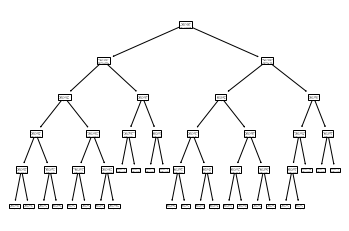

In [23]:
tree.plot_tree(dectree) 

In [24]:
Y = dectree.predict(test.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1))

In [25]:
decision_tree = tree.DecisionTreeClassifier(random_state=0, max_depth=5)
decision_tree = decision_tree.fit(train.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1), train['outcome'])
r = tree.export_text(decision_tree, feature_names=list(train.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1).columns))
print(r)

|--- ratio_dette_moy12m <= 0.15
|   |--- montant_part_patronale <= 7226.00
|   |   |--- rentabilite_economique <= -0.38
|   |   |   |--- productivite_capital_investi <= 1.10
|   |   |   |   |--- financier_court_terme <= 2.66
|   |   |   |   |   |--- class: False
|   |   |   |   |--- financier_court_terme >  2.66
|   |   |   |   |   |--- class: False
|   |   |   |--- productivite_capital_investi >  1.10
|   |   |   |   |--- paydex_yoy <= 0.50
|   |   |   |   |   |--- class: True
|   |   |   |   |--- paydex_yoy >  0.50
|   |   |   |   |   |--- class: False
|   |   |--- rentabilite_economique >  -0.38
|   |   |   |--- avg_delta_dette_par_effectif <= -370.41
|   |   |   |   |--- rentabilite_economique <= 8.44
|   |   |   |   |   |--- class: True
|   |   |   |   |--- rentabilite_economique >  8.44
|   |   |   |   |   |--- class: False
|   |   |   |--- avg_delta_dette_par_effectif >  -370.41
|   |   |   |   |--- rentabilite_nette <= -31.06
|   |   |   |   |   |--- class: True
|   |   |   |  

In [26]:
y_pred_dt = dectree.predict(train.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1))

In [27]:
confusion_matrix(list(train['outcome']),y_pred_dt)

array([[1695,    7],
       [ 113,  192]])

In [28]:
balanced_accuracy_score(list(train['outcome']),y_pred_dt)

0.8126976941303385

In [29]:
fbeta_score(list(train['outcome']),y_pred_dt,beta=2)

0.6765327695560254

In [30]:
precision_recall_fscore_support(list(train['outcome']),y_pred_dt,beta=2,average='binary')

(0.964824120603015, 0.6295081967213115, 0.6765327695560254, None)

Then we define and apply a SVM, then measure its metrics
====

In [43]:
SVM = make_pipeline(StandardScaler(), SVC(kernel='linear'))

In [44]:
SVM.fit(train.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1),train['outcome'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

In [45]:
y_pred_svm = SVM.predict(train.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1))

In [46]:
confusion_matrix(list(train['outcome']),y_pred_svm)

array([[1689,   13],
       [ 161,  144]])

In [47]:
balanced_accuracy_score(list(train['outcome']),y_pred_svm)

0.7322465373427598

In [48]:
precision_recall_fscore_support(list(train['outcome']),y_pred_svm,beta=2,average='binary')

(0.9171974522292994, 0.4721311475409836, 0.522875816993464, None)

Then we define and apply a RF of maximum depth equal to 5, then measure its metrics
====

In [53]:
RF = RandomForestClassifier(max_depth=5, random_state=0)

In [54]:
RF.fit(train.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1),train['outcome'])

RandomForestClassifier(max_depth=5, random_state=0)

In [58]:
y_pred_rf = RF.predict(train.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1))

In [59]:
confusion_matrix(list(train['outcome']),y_pred_rf)

array([[1699,    3],
       [ 130,  175]])

In [60]:
balanced_accuracy_score(list(train['outcome']),y_pred_rf)

0.786003929802932

In [61]:
precision_recall_fscore_support(list(train['outcome']),y_pred_rf,beta=2,average='binary')

(0.9831460674157303, 0.5737704918032787, 0.6258941344778254, None)

Then we define and apply a GB, then measure its metrics
====

In [87]:
GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=2, random_state=0)

In [88]:
GB.fit(train.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1),train['outcome'])

GradientBoostingClassifier(learning_rate=1.0, max_depth=2, random_state=0)

In [89]:
y_pred_gb = GB.predict(train.drop(['paydex_group','siret','periode','outcome','siren','code_naf','time_til_outcome'], axis=1))

In [90]:
confusion_matrix(list(train['outcome']),y_pred_gb)

array([[1696,    6],
       [  55,  250]])

In [91]:
balanced_accuracy_score(list(train['outcome']),y_pred_gb)

0.9080734333763557

In [92]:
precision_recall_fscore_support(list(train['outcome']),y_pred_gb,beta=2,average='binary')

(0.9765625, 0.819672131147541, 0.8468834688346883, None)